In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


# Homework description

Check models on overfitting: **OVERFIT MODELS!**
1. RandomForest with max_depth: 3, 5, 7, 9
2. GB with max_depth: 3, 5, 7, 9; estimators = 1000, 2000, 3000, ...
3. Create n-layer Dense network (examples n=3, 4, ..., neurons=1024, 2048, ...)

Evaluate model on test. Do you have overfit?

Prevent overfitting and obtain underfit on train:
1. Train RF, GB with max_depth in (1, 2, 3), estimators in (10, 25, 35)
2. Train NN with n=1, neurons=10

Try some methods to obtain hyperparameters (max_depth, n, estimators, neurons, ...)
- GridSearch
- Hyperopt, skopt

Have you received good results?

In [2]:
train_data = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")
test_data = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/test.csv")

In [3]:
y_train = np.log(train_data['SalePrice'])

In [4]:
numeric_columns = [i for i, j in zip(train_data.columns, train_data.dtypes) if j in [np.int64, np.float64] and i not in ['SalePrice', 'Id']]
x_train = train_data[numeric_columns].fillna(-1)
x_test = test_data[numeric_columns].fillna(-1)

In [2]:
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor


In [4]:
def rmse(a, b):
    return ((a - b) ** 2).mean() ** 0.5

Overfit and underfit task done only on default numeric columns 

**Overfit**

In [39]:
rf_metrics = []
max_depths = [3, 5, 7, 9]

K = 10

for max_depth in tqdm(max_depths):
    for k in range(K):
        x_tr, x_val, y_tr, y_val = train_test_split(x_train, y_train, random_state=k)
        model = RandomForestRegressor(max_depth=max_depth).fit(x_tr, y_tr)
        model.fit(x_tr, y_tr)
        y_pred_tr = model.predict(x_tr)
        y_pred_val = model.predict(x_val)
        rf_metrics.append({
            'algorithm' : f'RandomForest: max_depth={max_depth}',
            'train_mse' : rmse(y_tr, y_pred_tr),
            'val_mse' : rmse(y_val, y_pred_val)
        })

100%|██████████| 4/4 [00:52<00:00, 13.02s/it]


In [11]:
from scipy.stats import norm
alpha = 0.05

def check_overfit(metrics, a):
    metrics_df = pd.DataFrame(metrics)
    grouped_metrics_df = metrics_df.groupby(['algorithm']).agg(['mean', 'std', 'count'])

    # 95% confident interval
    xi = norm.ppf(1 - a / 2)

    confidence_intervals_train = []
    confidence_intervals_val = []

    for i in range(len(grouped_metrics_df)):
        confidence_intervals_train.append(
            np.array([-1, 1]) * xi * grouped_metrics_df.iloc[i]['train_mse']['std'] / grouped_metrics_df.iloc[i]['train_mse']['count'] ** 0.5 + grouped_metrics_df.iloc[i]['train_mse']['mean']
        )

        confidence_intervals_val.append(
            np.array([-1, 1]) * xi * grouped_metrics_df.iloc[i]['val_mse']['std'] / grouped_metrics_df.iloc[i]['val_mse']['count'] ** 0.5 + grouped_metrics_df.iloc[i]['val_mse']['mean']
        )

    grouped_metrics_df['conf_inter_train_left'] = [confidence_intervals_train_el[0] for confidence_intervals_train_el in confidence_intervals_train]
    grouped_metrics_df['conf_inter_train_right'] = [confidence_intervals_train_el[1] for confidence_intervals_train_el in confidence_intervals_train]
    grouped_metrics_df['conf_inter_val_left'] = [confidence_intervals_val_el[0] for confidence_intervals_val_el in confidence_intervals_val]
    grouped_metrics_df['conf_inter_val_right'] = [confidence_intervals_val_el[1] for confidence_intervals_val_el in confidence_intervals_val]
    intersection_start = max(grouped_metrics_df['conf_inter_train_left'][0], grouped_metrics_df['conf_inter_val_left'][0])
    intersection_end = min(grouped_metrics_df['conf_inter_train_right'][0], grouped_metrics_df['conf_inter_val_right'][0])
    grouped_metrics_df['overfitted_(no_intersection)'] = intersection_start > intersection_end
    
    return grouped_metrics_df

In [35]:
rf_metrics_df = check_overfit(rf_metrics, alpha)
rf_metrics_df

train_mse                   val_mse                  \
                               mean       std count      mean       std count   
algorithm                                                                       
RandomForest: max_depth=3  0.185071  0.001910    10  0.194034  0.009585    10   
RandomForest: max_depth=5  0.128614  0.001438    10  0.161850  0.008782    10   
RandomForest: max_depth=7  0.089880  0.001009    10  0.150179  0.011357    10   
RandomForest: max_depth=9  0.069187  0.001268    10  0.147249  0.010544    10   

                          conf_inter_train_left conf_inter_train_right  \
                                                                         
algorithm                                                                
RandomForest: max_depth=3              0.183887               0.186255   
RandomForest: max_depth=5              0.127723               0.129506   
RandomForest: max_depth=7              0.089254               0.090505   
RandomForest: max_depth=9              0.068401               0.069972   

                          conf_inter_val_left conf_inter_val_right  \
                                                                     
algorithm                                                            
RandomForest: max_depth=3            0.188093             0.199975   
RandomForest: max_depth=5            0.156407             0.167293   
RandomForest: max_depth=7            0.143140             0.157218   
RandomForest: max_depth=9            0.140714             0.153785   

                          overfitted_(no_intersection)  
                                                        
algorithm                                               
RandomForest: max_depth=3                         True  
RandomForest: max_depth=5                         True  
RandomForest: max_depth=7                         True  
RandomForest: max_depth=9                         True

In [41]:
gb_metrics = []
max_depths = [3, 5, 7, 9]
estimators = [1000, 2000, 3000, 4000]

K = 5

for max_depth in tqdm(max_depths):
    for n_estimators in tqdm(estimators):
        for k in range(K):
            x_tr, x_val, y_tr, y_val = train_test_split(x_train, y_train, random_state=k)
            model = GradientBoostingRegressor(max_depth=max_depth, n_estimators=n_estimators).fit(x_tr, y_tr)
            model.fit(x_tr, y_tr)
            y_pred_tr = model.predict(x_tr)
            y_pred_val = model.predict(x_val)
            gb_metrics.append({
            'algorithm' : f'GradientBoostingRegressor: max_depth={max_depth}, n_estimators={n_estimators}',
            'train_mse' : rmse(y_tr, y_pred_tr),
            'val_mse' : rmse(y_val, y_pred_val)
        })

100%|██████████| 4/4 [36:50<00:00, 552.65s/it]


In [42]:
gb_metrics_df = check_overfit(gb_metrics, alpha)
gb_metrics_df

train_mse                  \
                                                        mean       std count   
algorithm                                                                      
GradientBoostingRegressor: max_depth=3, n_estim...  0.017229  0.000611     5   
GradientBoostingRegressor: max_depth=3, n_estim...  0.004744  0.000223     5   
GradientBoostingRegressor: max_depth=3, n_estim...  0.001573  0.000234     5   
GradientBoostingRegressor: max_depth=3, n_estim...  0.000658  0.000378     5   
GradientBoostingRegressor: max_depth=5, n_estim...  0.000621  0.000375     5   
GradientBoostingRegressor: max_depth=5, n_estim...  0.000248  0.000545     5   
GradientBoostingRegressor: max_depth=5, n_estim...  0.000244  0.000547     5   
GradientBoostingRegressor: max_depth=5, n_estim...  0.000244  0.000547     5   
GradientBoostingRegressor: max_depth=7, n_estim...  0.000245  0.000546     5   
GradientBoostingRegressor: max_depth=7, n_estim...  0.000244  0.000547     5   
GradientBoostingRegressor: max_depth=7, n_estim...  0.000244  0.000547     5   
GradientBoostingRegressor: max_depth=7, n_estim...  0.000244  0.000547     5   
GradientBoostingRegressor: max_depth=9, n_estim...  0.000244  0.000547     5   
GradientBoostingRegressor: max_depth=9, n_estim...  0.000244  0.000547     5   
GradientBoostingRegressor: max_depth=9, n_estim...  0.000244  0.000547     5   
GradientBoostingRegressor: max_depth=9, n_estim...  0.000244  0.000547     5   

                                                     val_mse                  \
                                                        mean       std count   
algorithm                                                                      
GradientBoostingRegressor: max_depth=3, n_estim...  0.135900  0.020295     5   
GradientBoostingRegressor: max_depth=3, n_estim...  0.137023  0.019919     5   
GradientBoostingRegressor: max_depth=3, n_estim...  0.136563  0.020546     5   
GradientBoostingRegressor: max_depth=3, n_estim...  0.136440  0.019478     5   
GradientBoostingRegressor: max_depth=5, n_estim...  0.139248  0.013907     5   
GradientBoostingRegressor: max_depth=5, n_estim...  0.139951  0.015158     5   
GradientBoostingRegressor: max_depth=5, n_estim...  0.139515  0.013734     5   
GradientBoostingRegressor: max_depth=5, n_estim...  0.140101  0.014821     5   
GradientBoostingRegressor: max_depth=7, n_estim...  0.144748  0.011996     5   
GradientBoostingRegressor: max_depth=7, n_estim...  0.144306  0.010946     5   
GradientBoostingRegressor: max_depth=7, n_estim...  0.145134  0.012791     5   
GradientBoostingRegressor: max_depth=7, n_estim...  0.143927  0.011058     5   
GradientBoostingRegressor: max_depth=9, n_estim...  0.156565  0.010611     5   
GradientBoostingRegressor: max_depth=9, n_estim...  0.154298  0.009548     5   
GradientBoostingRegressor: max_depth=9, n_estim...  0.156693  0.012344     5   
GradientBoostingRegressor: max_depth=9, n_estim...  0.155832  0.010637     5   

                                                   conf_inter_train_left  \
                                                                           
algorithm                                                                  
GradientBoostingRegressor: max_depth=3, n_estim...              0.016694   
GradientBoostingRegressor: max_depth=3, n_estim...              0.004549   
GradientBoostingRegressor: max_depth=3, n_estim...              0.001367   
GradientBoostingRegressor: max_depth=3, n_estim...              0.000327   
GradientBoostingRegressor: max_depth=5, n_estim...              0.000292   
GradientBoostingRegressor: max_depth=5, n_estim...             -0.000229   
GradientBoostingRegressor: max_depth=5, n_estim...             -0.000235   
GradientBoostingRegressor: max_depth=5, n_estim...             -0.000235   
GradientBoostingRegressor: max_depth=7, n_estim...             -0.000234   
GradientBoostingRegressor: max_depth=7, n_estim...             -0.000235   
GradientBoostingRegre

In [52]:
nn_metrics = []
number_of_layers = [3, 4]
number_of_neurons = [1024, 2048]

K = 5

for n in number_of_layers:
    for neurons in number_of_neurons:
        for k in tqdm(range(K)):
            x_tr, x_val, y_tr, y_val = train_test_split(x_train, y_train, random_state=k)
            hidden_layer_sizes = tuple([neurons for _ in range(n)])
            model = MLPRegressor(hidden_layer_sizes=hidden_layer_sizes).fit(x_tr, y_tr)
            model.fit(x_tr, y_tr)
            y_pred_tr = model.predict(x_tr)
            y_pred_val = model.predict(x_val)
            nn_metrics.append({
            'algorithm' : f'MLPRegressor: hidden_layer_sizes={hidden_layer_sizes}',
            'train_mse' : rmse(y_tr, y_pred_tr),
            'val_mse' : rmse(y_val, y_pred_val)
            })
            
nn_metrics_df = check_overfit(nn_metrics, alpha)
nn_metrics_df

100%|██████████| 5/5 [30:30<00:00, 366.01s/it]


train_mse             \
                                                         mean        std   
algorithm                                                                  
MLPRegressor: hidden_layer_sizes=(1024, 1024, 1...   8.674837  10.369622   
MLPRegressor: hidden_layer_sizes=(1024, 1024, 1...  29.366833  47.798749   
MLPRegressor: hidden_layer_sizes=(2048, 2048, 2...  18.093187  19.550489   
MLPRegressor: hidden_layer_sizes=(2048, 2048, 2...   4.313043   2.491322   

                                                            val_mse  \
                                                   count       mean   
algorithm                                                             
MLPRegressor: hidden_layer_sizes=(1024, 1024, 1...     5   8.580655   
MLPRegressor: hidden_layer_sizes=(1024, 1024, 1...     5  28.237364   
MLPRegressor: hidden_layer_sizes=(2048, 2048, 2...     5  13.348070   
MLPRegressor: hidden_layer_sizes=(2048, 2048, 2...     5   4.188116   

                                                                     \
                                                          std count   
algorithm                                                             
MLPRegressor: hidden_layer_sizes=(1024, 1024, 1...  10.801008     5   
MLPRegressor: hidden_layer_sizes=(1024, 1024, 1...  46.994772     5   
MLPRegressor: hidden_layer_sizes=(2048, 2048, 2...   8.267285     5   
MLPRegressor: hidden_layer_sizes=(2048, 2048, 2...   2.468378     5   

                                                   conf_inter_train_left  \
                                                                           
algorithm                                                                  
MLPRegressor: hidden_layer_sizes=(1024, 1024, 1...             -0.414370   
MLPRegressor: hidden_layer_sizes=(1024, 1024, 1...            -12.529848   
MLPRegressor: hidden_layer_sizes=(2048, 2048, 2...              0.956743   
MLPRegressor: hidden_layer_sizes=(2048, 2048, 2...              2.129343   

                                                   conf_inter_train_right  \
                                                                            
algorithm                                                                   
MLPRegressor: hidden_layer_sizes=(1024, 1024, 1...              17.764045   
MLPRegressor: hidden_layer_sizes=(1024, 1024, 1...              71.263514   
MLPRegressor: hidden_layer_sizes=(2048, 2048, 2...              35.229631   
MLPRegressor: hidden_layer_sizes=(2048, 2048, 2...               6.496743   

                                                   conf_inter_val_left  \
                                                                         
algorithm                                                                
MLPRegressor: hidden_layer_sizes=(1024, 1024, 1...           -0.886671   
MLPRegressor: hidden_layer_sizes=(1024, 1024, 1...          -12.954613   
MLPRegressor: hidden_layer_sizes=(2048, 2048, 2...            6.101608   
MLPRegressor: hidden_layer_sizes=(2048, 2048, 2...            2.024527   

                                                   conf_inter_val_right  \
                                                                          
algorithm                                                                 
MLPRegressor: hidden_layer_sizes=(1024, 1024, 1...            18.047982   
MLPRegressor: hidden_layer_sizes=(1024, 1024, 1...            69.429341   
MLPRegressor: hidden_layer_sizes=(2048, 2048, 2...            20.594532   
MLPRegressor: hidden_layer_sizes=(2048, 2048, 2...             6.351705   

                                                   overfitted_(no_intersection)  
                                                                                 
algorithm                                                                        
MLPRegressor: hidden_layer_sizes=(1024, 1024, 1...                        False  
MLPRegressor: hidden_layer_sizes=(1024, 1024, 1...                        Fal

**Underfit**

In [16]:
rf_metrics_underfit = []
max_depths = [1, 2, 3]
estimators = [10, 25, 35]

K = 10

for max_depth in tqdm(max_depths):
    for n_estimators in tqdm(estimators):
        for k in range(K):
            x_tr, x_val, y_tr, y_val = train_test_split(x_train, y_train, random_state=k)
            model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth).fit(x_tr, y_tr)
            model.fit(x_tr, y_tr)
            y_pred_tr = model.predict(x_tr)
            y_pred_val = model.predict(x_val)
            rf_metrics_underfit.append({
                'algorithm' : f'RandomForest: n_estimators={n_estimators}, max_depth={max_depth}',
                'train_mse' : rmse(y_tr, y_pred_tr),
                'val_mse' : rmse(y_val, y_pred_val)
            })
        
rf_metrics_underfit_df = check_overfit(rf_metrics_underfit, alpha)
rf_metrics_underfit_df

100%|██████████| 3/3 [00:14<00:00,  4.77s/it]


train_mse                  \
                                                mean       std count   
algorithm                                                              
RandomForest: n_estimators=10, max_depth=1  0.294705  0.004201    10   
RandomForest: n_estimators=10, max_depth=2  0.231877  0.004568    10   
RandomForest: n_estimators=10, max_depth=3  0.187961  0.003160    10   
RandomForest: n_estimators=25, max_depth=1  0.294697  0.004192    10   
RandomForest: n_estimators=25, max_depth=2  0.229526  0.002406    10   
RandomForest: n_estimators=25, max_depth=3  0.186788  0.001717    10   
RandomForest: n_estimators=35, max_depth=1  0.294392  0.003798    10   
RandomForest: n_estimators=35, max_depth=2  0.229402  0.002767    10   
RandomForest: n_estimators=35, max_depth=3  0.185385  0.002323    10   

                                             val_mse                  \
                                                mean       std count   
algorithm                                                              
RandomForest: n_estimators=10, max_depth=1  0.287723  0.013006    10   
RandomForest: n_estimators=10, max_depth=2  0.233506  0.011158    10   
RandomForest: n_estimators=10, max_depth=3  0.197134  0.009275    10   
RandomForest: n_estimators=25, max_depth=1  0.287757  0.012927    10   
RandomForest: n_estimators=25, max_depth=2  0.229631  0.012493    10   
RandomForest: n_estimators=25, max_depth=3  0.196000  0.010960    10   
RandomForest: n_estimators=35, max_depth=1  0.287522  0.013366    10   
RandomForest: n_estimators=35, max_depth=2  0.230511  0.012198    10   
RandomForest: n_estimators=35, max_depth=3  0.194935  0.009952    10   

                                           conf_inter_train_left  \
                                                                   
algorithm                                                          
RandomForest: n_estimators=10, max_depth=1              0.292101   
RandomForest: n_estimators=10, max_depth=2              0.229046   
RandomForest: n_estimators=10, max_depth=3              0.186002   
RandomForest: n_estimators=25, max_depth=1              0.292098   
RandomForest: n_estimators=25, max_depth=2              0.228035   
RandomForest: n_estimators=25, max_depth=3              0.185724   
RandomForest: n_estimators=35, max_depth=1              0.292038   
RandomForest: n_estimators=35, max_depth=2              0.227687   
RandomForest: n_estimators=35, max_depth=3              0.183945   

                                           conf_inter_train_right  \
                                                                    
algorithm                                                           
RandomForest: n_estimators=10, max_depth=1               0.297309   
RandomForest: n_estimators=10, max_depth=2               0.234708   
RandomForest: n_estimators=10, max_depth=3               0.189920   
RandomForest: n_estimators=25, max_depth=1               0.297295   
RandomForest: n_estimators=25, max_depth=2               0.231017   
RandomForest: n_estimators=25, max_depth=3               0.187852   
RandomForest: n_estimators=35, max_depth=1               0.296747   
RandomForest: n_estimators=35, max_depth=2               0.231117   
RandomForest: n_estimators=35, max_depth=3               0.186825   

                                           conf_inter_val_left  \
                                                                 
algorithm                                                        
RandomForest: n_estimators=10, max_depth=1            0.279662   
RandomForest: n_estimators=10, max_depth=2            0.226590   
RandomForest: n_estimators=10, max_depth=3            0.191385   
RandomForest: n_estimators=25, max_depth=1            0.279745   
RandomForest: n_estimators=25, max_depth=2            0.221888   
RandomForest: n_estimators=25, max_depth=3            0.189207   
RandomForest: n_estimators=35, max_depth=1            0.279238   
RandomF

100%|██████████| 3/3 [00:01<00:00,  2.40it/s]


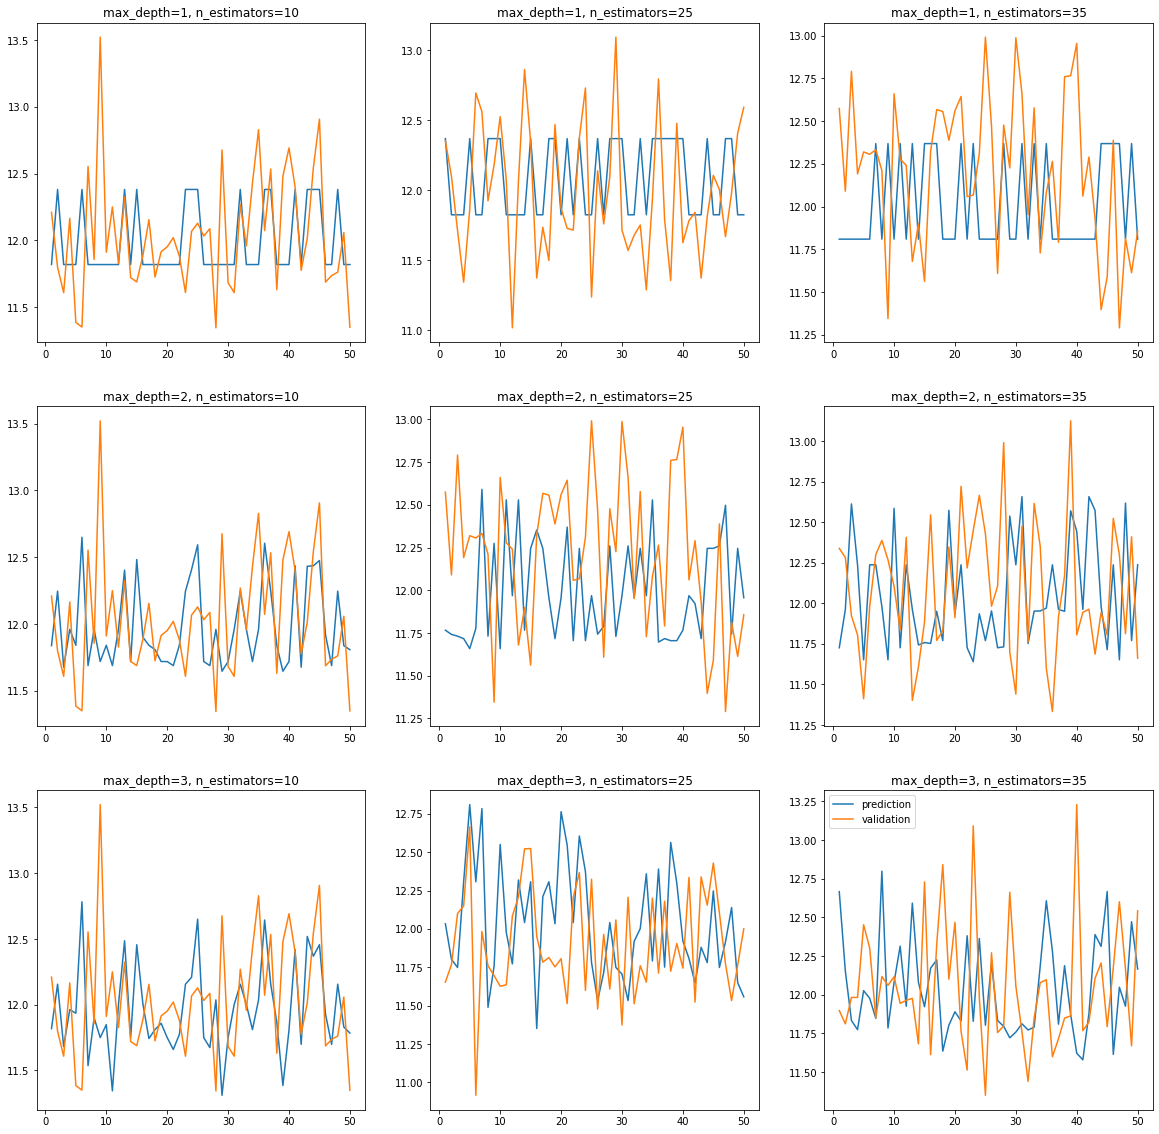

In [22]:
max_depths = [1, 2, 3]
estimators = [10, 25, 35]

plt.rcParams["figure.figsize"] = (20,20)

fig, axs = plt.subplots(len(max_depths), len(estimators))

for i, max_depth in enumerate(tqdm(max_depths)):
    for j, n_estimators in enumerate(tqdm(estimators)):
        x_tr, x_val, y_tr, y_val = train_test_split(x_train, y_train, random_state=j*(i+1))
        model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth).fit(x_tr, y_tr)
        model.fit(x_tr, y_tr)
        y_pred_tr = model.predict(x_tr)
        axs[i, j].plot(np.arange(start=1, stop=51), y_pred_tr[:50], label='prediction')
        axs[i, j].plot(np.arange(start=1, stop=51), y_val[:50], label='validation')
        axs[i, j].set_title(f'max_depth={max_depth}, n_estimators={n_estimators}')
        plt.legend()

In [13]:
gb_metrics_underfit = []
max_depths = [1, 2, 3]
estimators = [10, 25, 35]

K = 10

for max_depth in tqdm(max_depths):
    for n_estimators in tqdm(estimators):
        for k in range(K):
            x_tr, x_val, y_tr, y_val = train_test_split(x_train, y_train, random_state=k)
            model = GradientBoostingRegressor(max_depth=max_depth, n_estimators=n_estimators).fit(x_tr, y_tr)
            model.fit(x_tr, y_tr)
            y_pred_tr = model.predict(x_tr)
            y_pred_val = model.predict(x_val)
            gb_metrics_underfit.append({
            'algorithm' : f'GradientBoostingRegressor: max_depth={max_depth}, n_estimators={n_estimators}',
            'train_mse' : rmse(y_tr, y_pred_tr),
            'val_mse' : rmse(y_val, y_pred_val)
        })

gb_metrics_underfit_df = check_overfit(gb_metrics_underfit, alpha)
gb_metrics_underfit_df

100%|██████████| 3/3 [00:13<00:00,  4.66s/it]


train_mse                  \
                                                        mean       std count   
algorithm                                                                      
GradientBoostingRegressor: max_depth=1, n_estim...  0.289477  0.003342    10   
GradientBoostingRegressor: max_depth=1, n_estim...  0.220954  0.002635    10   
GradientBoostingRegressor: max_depth=1, n_estim...  0.196626  0.002163    10   
GradientBoostingRegressor: max_depth=2, n_estim...  0.245752  0.002568    10   
GradientBoostingRegressor: max_depth=2, n_estim...  0.165925  0.002182    10   
GradientBoostingRegressor: max_depth=2, n_estim...  0.144716  0.002302    10   
GradientBoostingRegressor: max_depth=3, n_estim...  0.219975  0.002510    10   
GradientBoostingRegressor: max_depth=3, n_estim...  0.135469  0.001848    10   
GradientBoostingRegressor: max_depth=3, n_estim...  0.116131  0.001820    10   

                                                     val_mse                  \
                                                        mean       std count   
algorithm                                                                      
GradientBoostingRegressor: max_depth=1, n_estim...  0.284087  0.014580    10   
GradientBoostingRegressor: max_depth=1, n_estim...  0.218487  0.013729    10   
GradientBoostingRegressor: max_depth=1, n_estim...  0.196525  0.012133    10   
GradientBoostingRegressor: max_depth=2, n_estim...  0.244374  0.013565    10   
GradientBoostingRegressor: max_depth=2, n_estim...  0.173754  0.009391    10   
GradientBoostingRegressor: max_depth=2, n_estim...  0.156844  0.008024    10   
GradientBoostingRegressor: max_depth=3, n_estim...  0.224614  0.012726    10   
GradientBoostingRegressor: max_depth=3, n_estim...  0.156139  0.009126    10   
GradientBoostingRegressor: max_depth=3, n_estim...  0.144413  0.009727    10   

                                                   conf_inter_train_left  \
                                                                           
algorithm                                                                  
GradientBoostingRegressor: max_depth=1, n_estim...              0.287406   
GradientBoostingRegressor: max_depth=1, n_estim...              0.219320   
GradientBoostingRegressor: max_depth=1, n_estim...              0.195285   
GradientBoostingRegressor: max_depth=2, n_estim...              0.244161   
GradientBoostingRegressor: max_depth=2, n_estim...              0.164573   
GradientBoostingRegressor: max_depth=2, n_estim...              0.143289   
GradientBoostingRegressor: max_depth=3, n_estim...              0.218419   
GradientBoostingRegressor: max_depth=3, n_estim...              0.134324   
GradientBoostingRegressor: max_depth=3, n_estim...              0.115003   

                                                   conf_inter_train_right  \
                                                                            
algorithm                                                                   
GradientBoostingRegressor: max_depth=1, n_estim...               0.291549   
GradientBoostingRegressor: max_depth=1, n_estim...               0.222587   
GradientBoostingRegressor: max_depth=1, n_estim...               0.197967   
GradientBoostingRegressor: max_depth=2, n_estim...               0.247343   
GradientBoostingRegressor: max_depth=2, n_estim...               0.167277   
GradientBoostingRegressor: max_depth=2, n_estim...               0.146142   
GradientBoostingRegressor: max_depth=3, n_estim...               0.221530   
GradientBoostingRegressor: max_depth=3, n_estim...               0.136614   
GradientBoostingRegressor: max_depth=3, n_estim...               0.117259   

                                                   conf_inter_val_left  \
                                                                         
algorithm                                                                
GradientBoostingRegressor: max_depth=1, n_estim...            0.27505

100%|██████████| 3/3 [00:01<00:00,  2.53it/s]


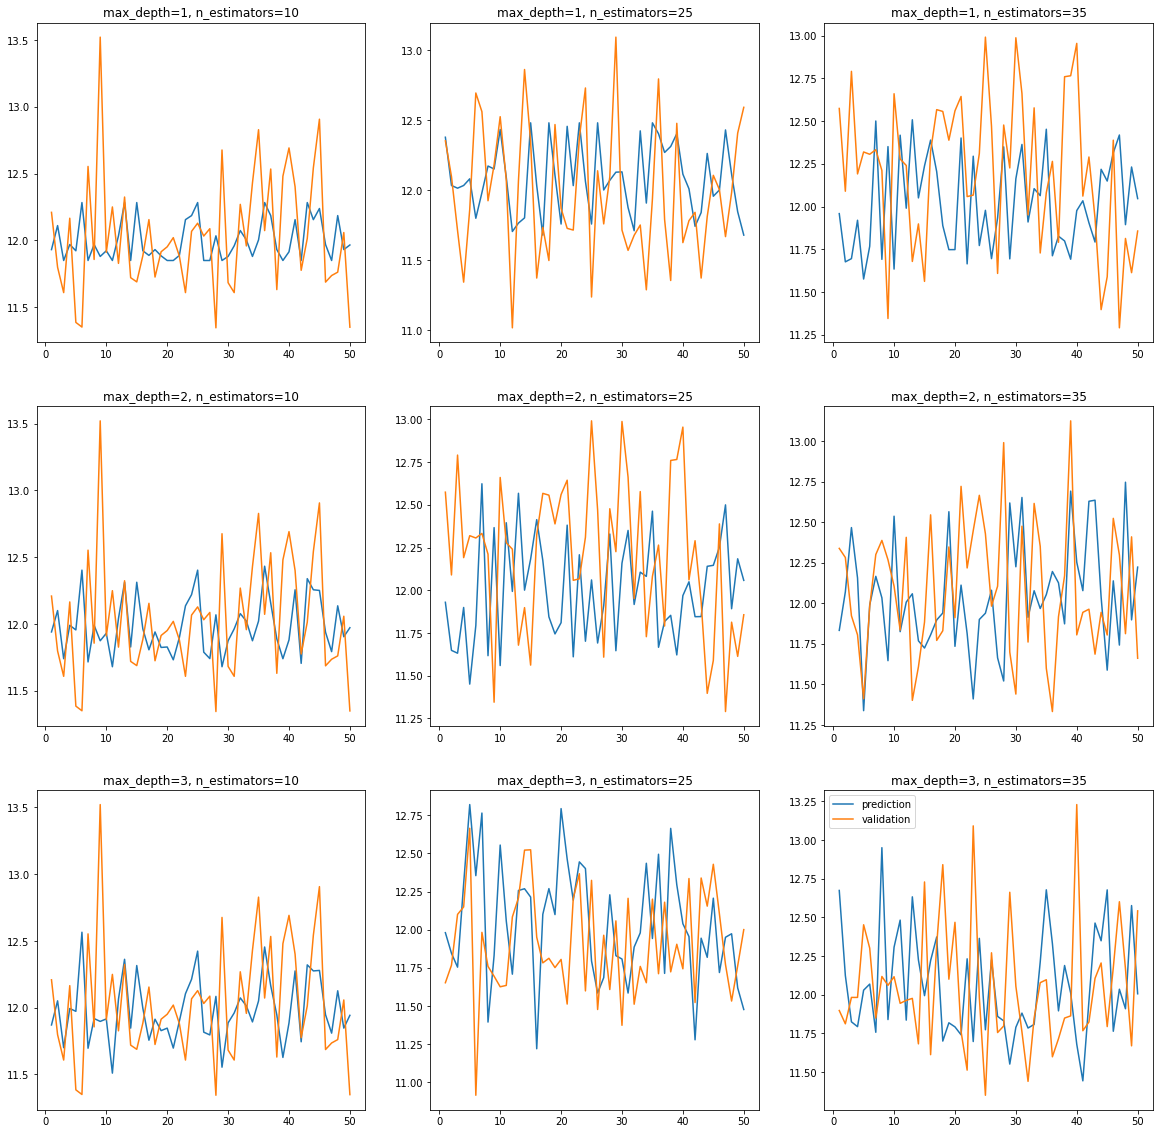

In [23]:
plt.rcParams["figure.figsize"] = (20,20)

fig, axs = plt.subplots(len(max_depths), len(estimators))

for i, max_depth in enumerate(tqdm(max_depths)):
    for j, n_estimators in enumerate(tqdm(estimators)):
        x_tr, x_val, y_tr, y_val = train_test_split(x_train, y_train, random_state=j*(i+1))
        model = GradientBoostingRegressor(max_depth=max_depth, n_estimators=n_estimators).fit(x_tr, y_tr)
        model.fit(x_tr, y_tr)
        y_pred_tr = model.predict(x_tr)
        axs[i, j].plot(np.arange(start=1, stop=51), y_pred_tr[:50], label='prediction')
        axs[i, j].plot(np.arange(start=1, stop=51), y_val[:50], label='validation')
        axs[i, j].set_title(f'max_depth={max_depth}, n_estimators={n_estimators}')
        plt.legend()

In [15]:
nn_metrics_underfit = []
hidden_layer_sizes = (10, )
K = 10

for k in tqdm(range(K)):
    x_tr, x_val, y_tr, y_val = train_test_split(x_train, y_train, random_state=k)
    model = MLPRegressor(hidden_layer_sizes=hidden_layer_sizes).fit(x_tr, y_tr)
    model.fit(x_tr, y_tr)
    y_pred_tr = model.predict(x_tr)
    y_pred_val = model.predict(x_val)
    nn_metrics_underfit.append({
    'algorithm' : f'MLPRegressor: hidden_layer_sizes={hidden_layer_sizes}',
    'train_mse' : rmse(y_tr, y_pred_tr),
    'val_mse' : rmse(y_val, y_pred_val)
    })
                
nn_metrics_underfit_df = check_overfit(nn_metrics_underfit, alpha)
nn_metrics_underfit_df

  0%|          | 0/10 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
 10%|█         | 1/10 [00:01<00:09,  1.05s/it]/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  Conv

train_mse                     val_mse  \
                                             mean        std count       mean   
algorithm                                                                       
MLPRegressor: hidden_layer_sizes=(10,)  33.755494  42.486483    10  45.987476   

                                                        conf_inter_train_left  \
                                              std count                         
algorithm                                                                       
MLPRegressor: hidden_layer_sizes=(10,)  53.070534    10              7.422583   

                                       conf_inter_train_right  \
                                                                
algorithm                                                       
MLPRegressor: hidden_layer_sizes=(10,)              60.088405   

                                       conf_inter_val_left  \
                                                             
algorithm                                                    
MLPRegressor: hidden_layer_sizes=(10,)           13.094623   

                                       conf_inter_val_right  \
                                                              
algorithm                                                     
MLPRegressor: hidden_layer_sizes=(10,)             78.88033   

                                       overfitted_(no_intersection)  
                                                                     
algorithm                                                            
MLPRegressor: hidden_layer_sizes=(10,)                        False

/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


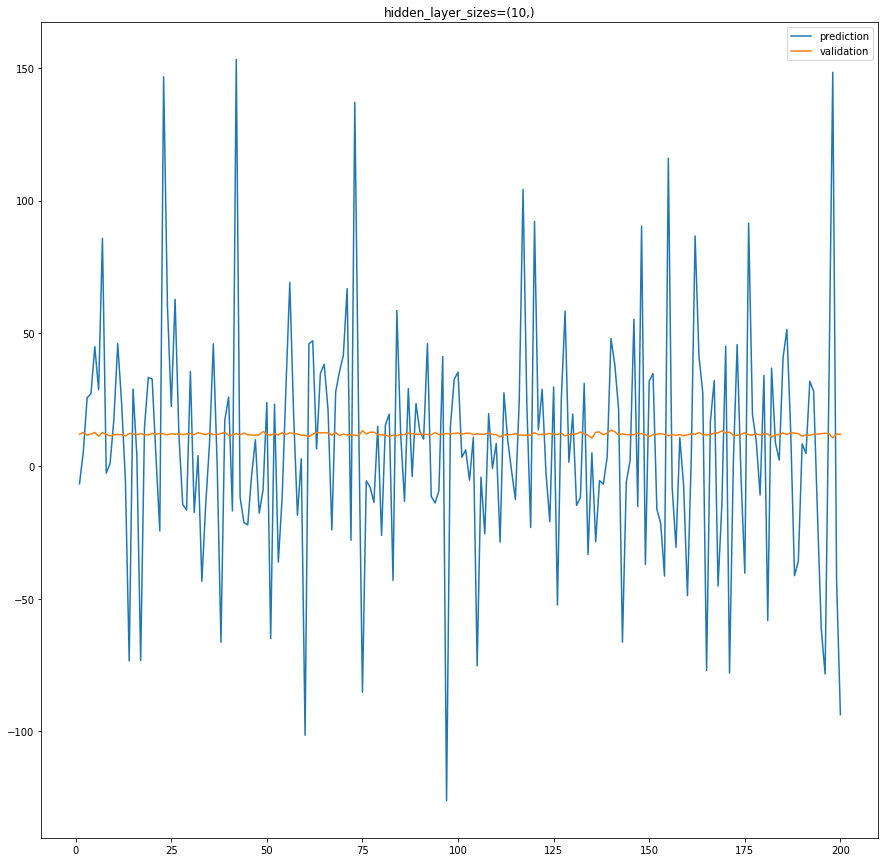

In [24]:
plt.rcParams["figure.figsize"] = (15, 15)

hidden_layer_sizes = (10, )

x_tr, x_val, y_tr, y_val = train_test_split(x_train, y_train, random_state=42)
model = MLPRegressor(hidden_layer_sizes=hidden_layer_sizes).fit(x_tr, y_tr)
model.fit(x_tr, y_tr)
y_pred_tr = model.predict(x_tr)
plt.plot(np.arange(start=1, stop=201), y_pred_tr[:200], label='prediction')
plt.plot(np.arange(start=1, stop=201), y_val[:200], label='validation')
plt.title(f'hidden_layer_sizes={hidden_layer_sizes}')
plt.legend()
plt.show()

In [14]:
from catboost import CatBoostRegressor
from catboost import Pool
from hyperopt import hp, tpe, fmin, Trials, STATUS_OK
from sklearn.model_selection import KFold

In [20]:
import time

In [35]:
x_train = train_data[numeric_columns]

model_cpu = CatBoostRegressor()
start = time.time()
model_cpu.fit(x_train, y_train, verbose=False)
end = time.time()
print('CPU time: ', end - start)

CPU time:  4.3830406665802


In [18]:
model_gpu = CatBoostRegressor(task_type='GPU')
start = time.time()
model_gpu.fit(x_train, y_train, verbose=False)
end = time.time()
print('GPU time: ', end - start)

GPU time:  10.915719747543335


**Some preprocessing done - transform some of numerical columns to categories**

**hyperopt**

In [5]:
train_data = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")
test_data = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/test.csv")
y_train = np.log(train_data['SalePrice'])
numeric_columns = [i for i, j in zip(train_data.columns, train_data.dtypes) if j in [np.int64, np.float64] and i not in ['SalePrice', 'Id']]
for column in numeric_columns:
    print(f'{column}: ', len(train_data[column].unique()))

MSSubClass:  15
LotFrontage:  111
LotArea:  1073
OverallQual:  10
OverallCond:  9
YearBuilt:  112
YearRemodAdd:  61
MasVnrArea:  328
BsmtFinSF1:  637
BsmtFinSF2:  144
BsmtUnfSF:  780
TotalBsmtSF:  721
1stFlrSF:  753
2ndFlrSF:  417
LowQualFinSF:  24
GrLivArea:  861
BsmtFullBath:  4
BsmtHalfBath:  3
FullBath:  4
HalfBath:  3
BedroomAbvGr:  8
KitchenAbvGr:  4
TotRmsAbvGrd:  12
Fireplaces:  4
GarageYrBlt:  98
GarageCars:  5
GarageArea:  441
WoodDeckSF:  274
OpenPorchSF:  202
EnclosedPorch:  120
3SsnPorch:  20
ScreenPorch:  76
PoolArea:  8
MiscVal:  21
MoSold:  12
YrSold:  5


Columns selected for change were picked in a naive way

In [6]:
columns_to_categorical = ['MSSubClass', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'LowQualFinSF', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'PoolArea', 'MoSold', 'YrSold']
train_data[columns_to_categorical]

,MSSubClass,OverallQual,OverallCond,YearBuilt,YearRemodAdd,LowQualFinSF,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,PoolArea,MoSold,YrSold
0,60,7,5,2003,2003,0,1,0,2,1,3,1,8,0,2003.0,2,0,2,2008
1,20,6,8,1976,1976,0,0,1,2,0,3,1,6,1,1976.0,2,0,5,2007
2,60,7,5,2001,2002,0,1,0,2,1,3,1,6,1,2001.0,2,0,9,2008
3,70,7,5,1915,1970,0,1,0,1,0,3,1,7,1,1998.0,3,0,2,2006
4,60,8,5,2000,2000,0,1,0,2,1,4,1,9,1,2000.0,3,0,12,2008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,6,5,1999,2000,0,0,0,2,1,3,1,7,1,1999.0,2,0,8,2007
1456,20,6,6,1978,1988,0,1,0,2,0,3,1,7,2,1978.0,2,0,2,2010
1457,70,7,9,1941,2006,0,0,0,2,0,4,1,9,2,1941.0,1,0,5,2010
1458,20,5,6,1950,1996,0,1,0,1,0,2,1,5,0,1950.0,1,0,4,2010


In [7]:
train_data['GarageYrBlt'] = train_data['GarageYrBlt'].fillna(-1)
train_data['GarageYrBlt'] = train_data['GarageYrBlt'].astype(int)
train_data['GarageYrBlt']

0       2003
1       1976
2       2001
3       1998
4       2000
        ... 
1455    1999
1456    1978
1457    1941
1458    1950
1459    1965
Name: GarageYrBlt, Length: 1460, dtype: int64

In [8]:
train_data[columns_to_categorical] = train_data[columns_to_categorical].astype('object')

categorical_columns = [i for i, j in zip(train_data.columns, train_data.dtypes) if j not in [np.int64, np.float64]]
numeric_columns = [i for i, j in zip(train_data.columns, train_data.dtypes) if j in [np.int64, np.float64] and i not in ['SalePrice', 'Id']]

train_data[numeric_columns] = train_data[numeric_columns].fillna(-1)

train_data[categorical_columns] = train_data[categorical_columns].fillna("Other")
train_data.isna().sum()[train_data.isna().sum() > 0]

Series([], dtype: int64)

In [16]:
x_train = train_data[numeric_columns + categorical_columns]

In [94]:
space= {'n_estimators' : hp.quniform('n_estimators', 50, 500, 5),
        'learning_rate' : hp.quniform('learning_rate', 0.01, 0.1, 0.01),
        'depth':hp.quniform('depth', 3, 10, 1),
       }


kf = KFold(n_splits=5)

# RMSE is the default loss function
def objective(space):
    rmses = []
    for tr_index, val_index in kf.split(x_train):
        x_tr, y_tr = x_train.iloc[tr_index], y_train.iloc[tr_index]
        x_val, y_val = x_train.iloc[val_index], y_train.iloc[val_index]
        pool_tr = Pool(x_tr, y_tr, cat_features=categorical_columns)
        pool_val = Pool(x_val, cat_features=categorical_columns)
        model = CatBoostRegressor(**space, verbose=False)
        model.fit(pool_tr)
        y_pred = model.predict(pool_val)
        rmses.append(rmse(y_val, y_pred))
        
    return np.mean(rmses)


trials = Trials()
best = fmin(objective,
    space=space,
    algo=tpe.suggest,
    max_evals=50,
    trials=trials)

print(best)
print(trials.results)

100%|██████████| 50/50 [1:41:52<00:00, 122.25s/trial, best loss: 0.12563551287187083]
{'depth': 6.0, 'learning_rate': 0.06, 'n_estimators': 465.0}
[{'loss': 0.13049210917967155, 'status': 'ok'}, {'loss': 0.137691230152725, 'status': 'ok'}, {'loss': 0.15535483016709115, 'status': 'ok'}, {'loss': 0.14089466195917416, 'status': 'ok'}, {'loss': 0.13028843153636743, 'status': 'ok'}, {'loss': 0.13929924838984137, 'status': 'ok'}, {'loss': 0.18654147137320193, 'status': 'ok'}, {'loss': 0.13140892663365408, 'status': 'ok'}, {'loss': 0.12913650347784114, 'status': 'ok'}, {'loss': 0.12979271254039218, 'status': 'ok'}, {'loss': 0.13231776090564512, 'status': 'ok'}, {'loss': 0.13566718018073906, 'status': 'ok'}, {'loss': 0.13054849790510423, 'status': 'ok'}, {'loss': 0.12827416651498585, 'status': 'ok'}, {'loss': 0.12851618183441996, 'status': 'ok'}, {'loss': 0.13205138505611072, 'status': 'ok'}, {'loss': 0.1288516477062127, 'status': 'ok'}, {'loss': 0.15991389363856887, 'status': 'ok'}, {'loss': 

In [9]:
test_data[columns_to_categorical]

,MSSubClass,OverallQual,OverallCond,YearBuilt,YearRemodAdd,LowQualFinSF,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,PoolArea,MoSold,YrSold
0,20,5,6,1961,1961,0,0.0,0.0,1,0,2,1,5,0,1961.0,1.0,0,6,2010
1,20,6,6,1958,1958,0,0.0,0.0,1,1,3,1,6,0,1958.0,1.0,0,6,2010
2,60,5,5,1997,1998,0,0.0,0.0,2,1,3,1,6,1,1997.0,2.0,0,3,2010
3,60,6,6,1998,1998,0,0.0,0.0,2,1,3,1,7,1,1998.0,2.0,0,6,2010
4,120,8,5,1992,1992,0,0.0,0.0,2,0,2,1,5,0,1992.0,2.0,0,1,2010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,160,4,7,1970,1970,0,0.0,0.0,1,1,3,1,5,0,NaN,0.0,0,6,2006
1455,160,4,5,1970,1970,0,0.0,0.0,1,1,3,1,6,0,1970.0,1.0,0,4,2006
1456,20,5,7,1960,1996,0,1.0,0.0,1,0,4,1,7,1,1960.0,2.0,0,9,2006
1457,85,5,5,1992,1992,0,0.0,1.0,1,0,3,1,6,0,NaN,0.0,0,7,2006


In [10]:
for column in columns_to_categorical:
    if test_data[column].dtype == 'float64':
        test_data[column] = test_data[column].fillna(-1)
        test_data[column] = test_data[column].astype('int')

In [11]:
test_data[columns_to_categorical] = test_data[columns_to_categorical].astype('object')
test_data[numeric_columns] = test_data[numeric_columns].fillna(-1)
test_data[categorical_columns] = test_data[categorical_columns].fillna("Other")

In [12]:
test_data.dtypes

Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
                  ...   
MiscVal            int64
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
Length: 80, dtype: object

In [17]:
x_test = test_data[numeric_columns + categorical_columns]

model = CatBoostRegressor(verbose=False, depth=6, n_estimators=465, learning_rate=0.06)
pool_train = Pool(x_train, y_train, cat_features=categorical_columns)
pool_test = Pool(x_test, cat_features=categorical_columns)
model.fit(pool_train)
y_pred = model.predict(pool_test)

submit = pd.DataFrame()
submit['Id'] = test_data['Id']
submit['SalePrice'] = np.exp(y_pred)
submit

,Id,SalePrice
0,1461,118448.102818
1,1462,161047.841433
2,1463,183803.147080
3,1464,198326.674704
4,1465,192912.434761
...,...,...
1454,2915,81760.429511
1455,2916,80946.499582
1456,2917,159397.941405
1457,2918,111195.863550


In [163]:
submit.to_csv('/kaggle/working/catboost_hyperopt_num_to_cat.csv', index=False)